# Datos

In [1]:
#paquetes locales diseñados para nuestro caso de estudio
from localpacks.data import get_data 


#datasets
import numpy as np
import pandas as pd

#utilidades para los mapas
import os
import folium
import contextily as ctx #la usamos para agregar un mapa de fondo

#API maps
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
#draw map streets
import osmnx as ox
import geopandas

#graficos
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

### Obtenemos nuestros datos

In [2]:
cordoba_sf = get_data()

In [3]:
cordoba_sf.head(3)

,toponimo_i,link,varon,mujer,totalpobl,hogares,viviendasp,viv_part_h,geometry
0,336422,141750202,246.0,211.0,457.0,155.0,248.0,151.0,"POLYGON ((3686668.391348725 6672098.301358264,..."
1,336421,141470304,211.0,223.0,434.0,125.0,318.0,121.0,"POLYGON ((3651995.370083685 6492136.442240674,..."
2,336420,141470302,203.0,168.0,371.0,105.0,117.0,44.0,"POLYGON ((3646477.920536898 6501399.587313074,..."


Podemos observar que los datos corresponden a los de la descripción del **README.md**

## 1. Alternativa para visualizar los datos CENTROIDES

Algunas de las áreas colindantes de los radios censales que representan las zonas de alta densidad de población se solapan entre sí, dado que el nivel de detalle requiere una alta resolución para apreciar el detalle, por lo que una alternativa es representar cada área mediante su centroide.

In [4]:
cordoba_sf_centroid = cordoba_sf.copy()

In [5]:
cordoba_sf_centroid['geometry'] = cordoba_sf_centroid.centroid

In [6]:
cordoba_sf_centroid.head()

,toponimo_i,link,varon,mujer,totalpobl,hogares,viviendasp,viv_part_h,geometry
0,336422,141750202,246.0,211.0,457.0,155.0,248.0,151.0,POINT (3697241.763885154 6662169.957066355)
1,336421,141470304,211.0,223.0,434.0,125.0,318.0,121.0,POINT (3655866.806322498 6489631.934621866)
2,336420,141470302,203.0,168.0,371.0,105.0,117.0,44.0,POINT (3643878.53016293 6499528.634456442)
3,336419,140700210,119.0,124.0,243.0,88.0,139.0,86.0,POINT (3586756.529598954 6544557.268892568)
4,336418,140280706,142.0,108.0,250.0,79.0,146.0,77.0,POINT (3601623.298581214 6553883.718494492)


Vemos que ahora la geometry ahora es solo un **POINT**, es decir, el centroide de cada **POLYGON**

C:\Users\USUARIO\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


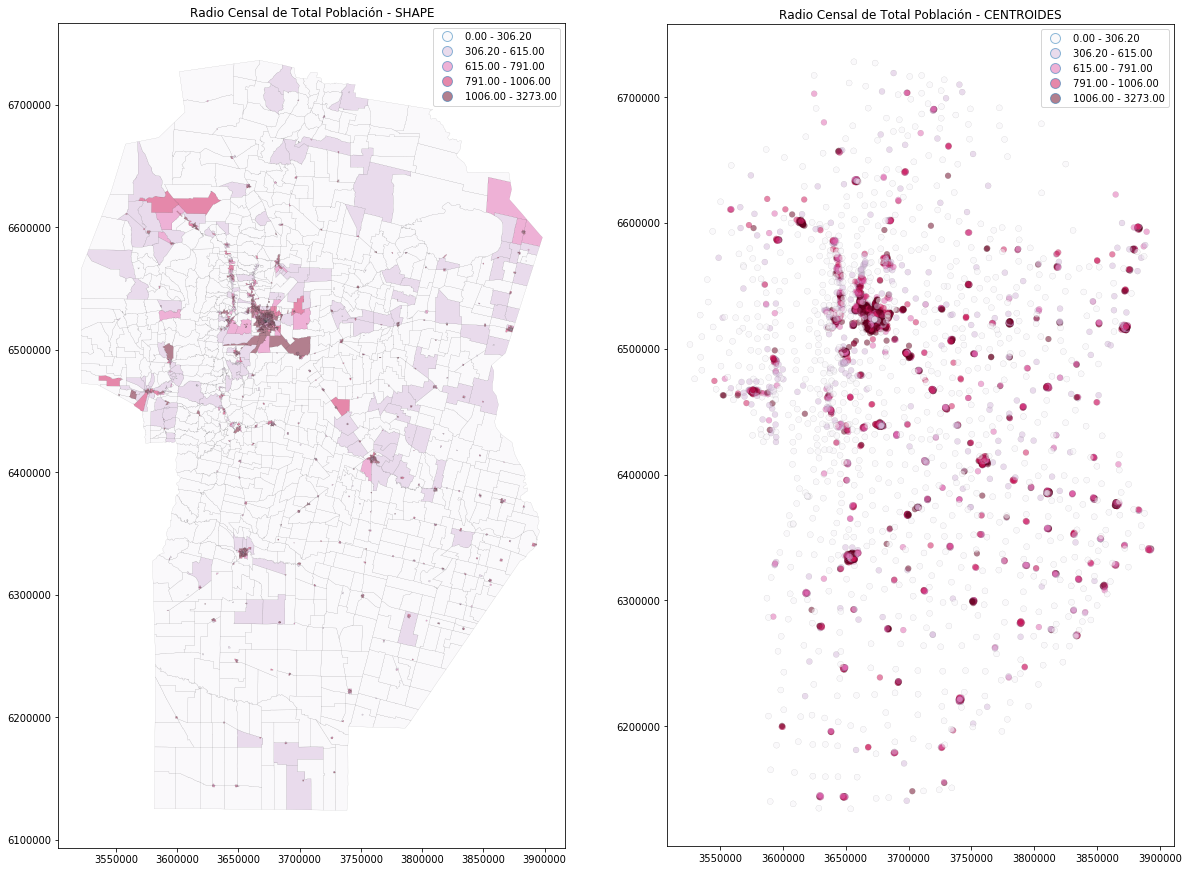

In [7]:
f,ax = plt.subplots(1,2,figsize=(20,20))

#Datos a plotear
cordoba_sf.plot(column='totalpobl', edgecolor='k', ax=ax[0], alpha=.5, cmap='PuRd', scheme='quantiles', legend=True, linewidth=.1,)
cordoba_sf_centroid.plot(column='totalpobl', edgecolor='k', ax=ax[1], alpha=.5, cmap='PuRd', scheme='quantiles', legend=True, linewidth=.1,)

#Datos de los plotters
ax[0].set_title('Radio Censal de Total Población - SHAPE')
ax[1].set_title('Radio Censal de Total Población - CENTROIDES')

plt.show();

## 2. Reindexar por LINK

In [8]:
cordoba_sf_ordered_topo = cordoba_sf.set_index('toponimo_i')
cordoba_sf_ordered_link = cordoba_sf.set_index('link')

In [9]:
cordoba_sf_ordered_topo = cordoba_sf_ordered_topo.sort_index()
cordoba_sf_ordered_link = cordoba_sf_ordered_link.sort_index()

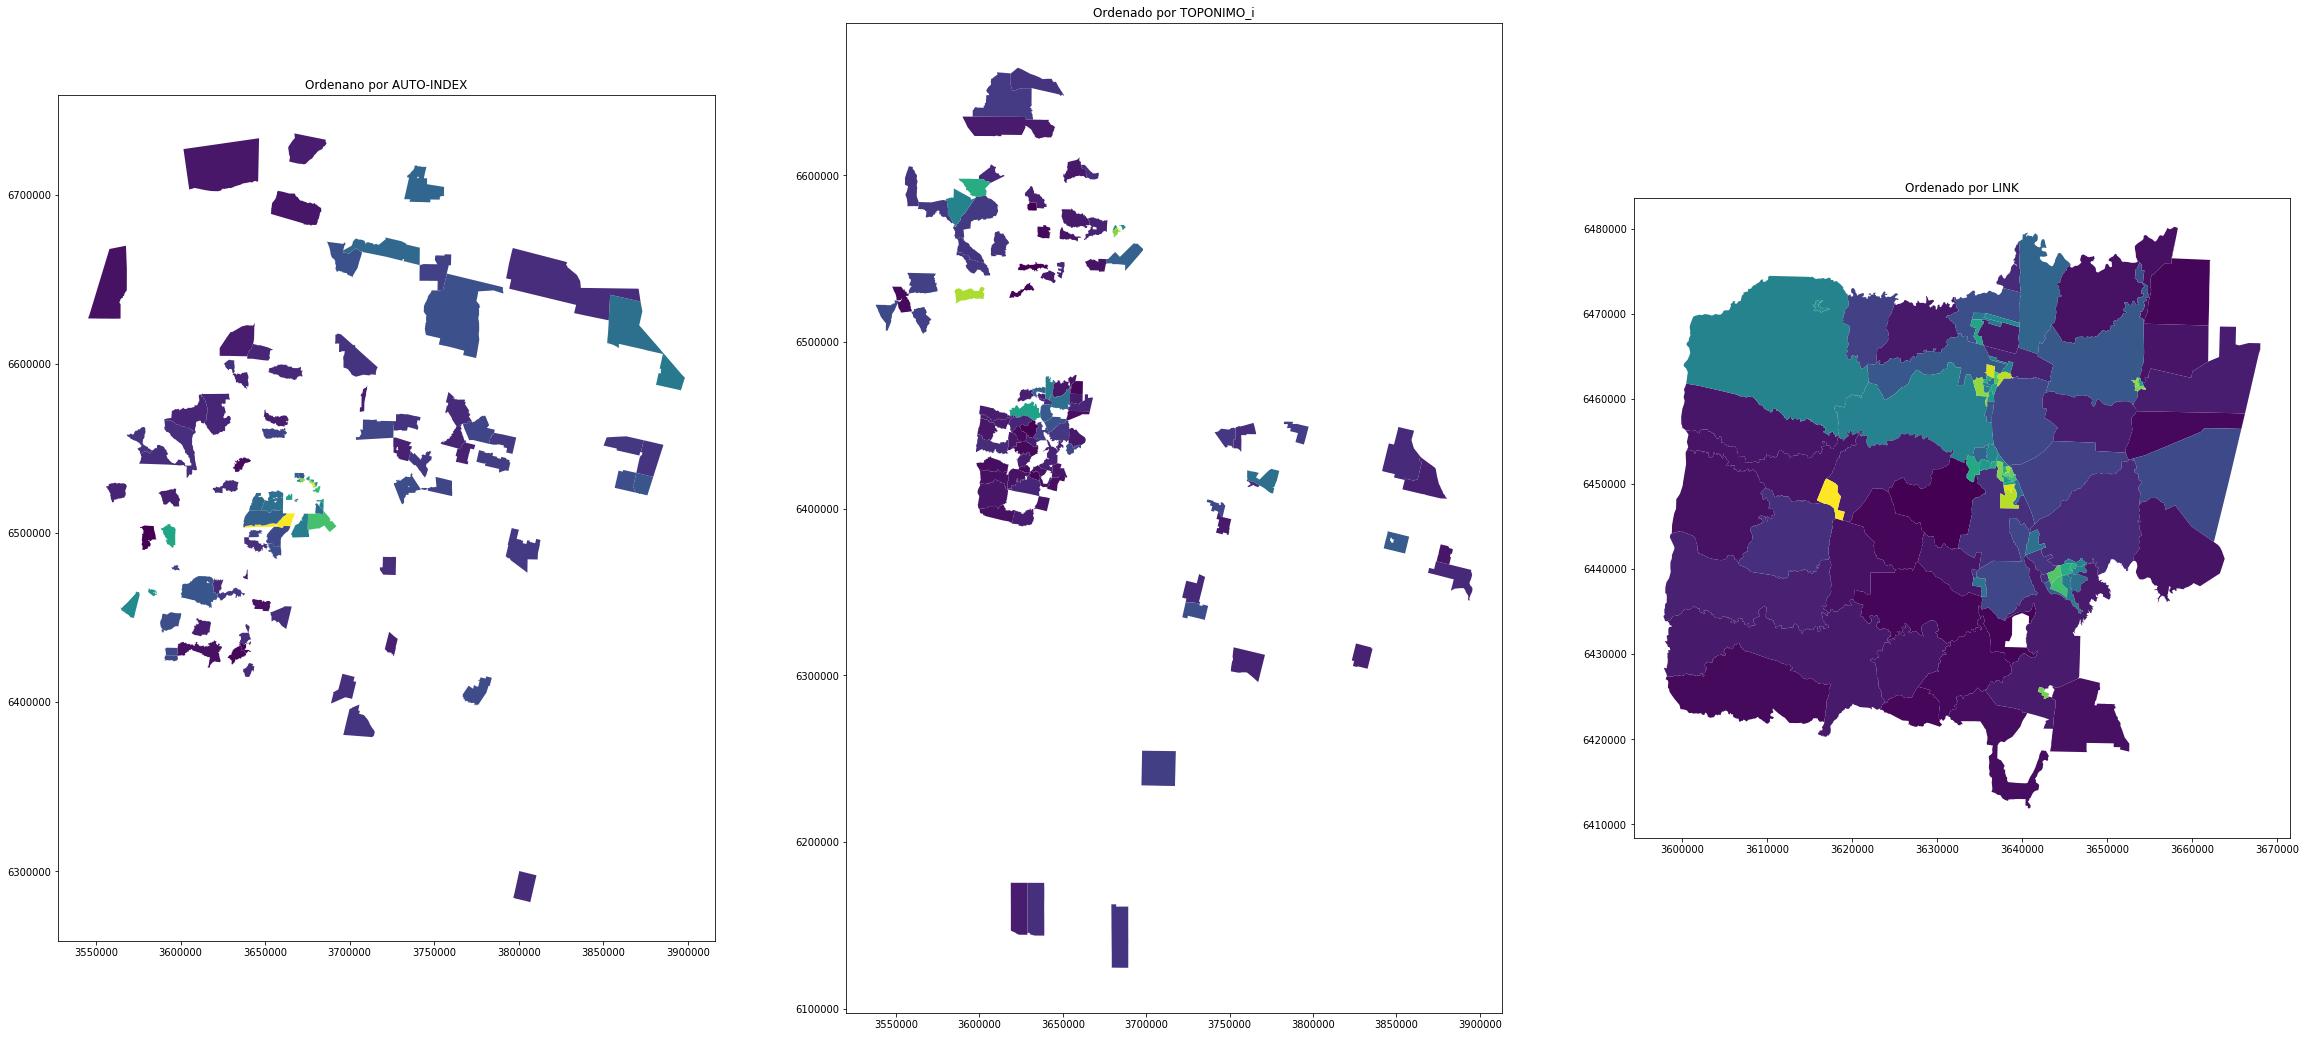

In [10]:
f,ax = plt.subplots(1,3,figsize=(20*2,20))

#Datos a plotear
cordoba_sf[:100].plot(column='totalpobl', ax=ax[0])
cordoba_sf_ordered_topo[:100].plot(column='totalpobl', ax=ax[1])
cordoba_sf_ordered_link[:100].plot(column='totalpobl', ax=ax[2])

#Datos de los plotters
ax[0].set_title('Ordenano por AUTO-INDEX')
ax[1].set_title('Ordenado por TOPONIMO_i')
ax[2].set_title('Ordenado por LINK')

plt.show();

Observamos que para los primeros 100 rows, parace que el orden secuencial se deriva del atributo **LINK**, con esto resulta posible hacer un zoom en las zonas de interés.

## 3. Proyectando nuestros puntos en 3D

In [11]:
cordoba_sf["longitude"] = cordoba_sf.centroid.map(lambda p: p.x) #extraemos los pares de puntos longitud y latitud de cada centroide
cordoba_sf["latitude"] = cordoba_sf.centroid.map(lambda p: p.y)

In [12]:
cordoba_sf.head(3)

,toponimo_i,link,varon,mujer,totalpobl,hogares,viviendasp,viv_part_h,geometry,longitude,latitude
0,336422,141750202,246.0,211.0,457.0,155.0,248.0,151.0,"POLYGON ((3686668.391348725 6672098.301358264,...",3.697242e+06,6.662170e+06
1,336421,141470304,211.0,223.0,434.0,125.0,318.0,121.0,"POLYGON ((3651995.370083685 6492136.442240674,...",3.655867e+06,6.489632e+06
2,336420,141470302,203.0,168.0,371.0,105.0,117.0,44.0,"POLYGON ((3646477.920536898 6501399.587313074,...",3.643879e+06,6.499529e+06


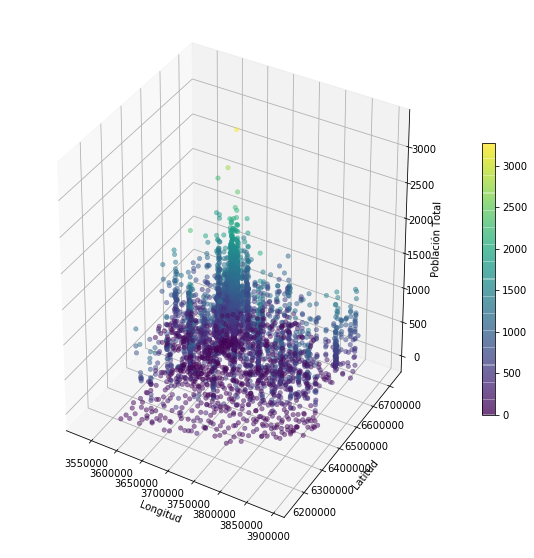

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Data for three-dimensional scattered points
zdata = cordoba_sf.totalpobl
xdata = cordoba_sf.longitude
ydata = cordoba_sf.latitude



p_scatter= ax.scatter3D(xdata, ydata, zdata, c=zdata,cmap='viridis', linewidth=0.5, alpha=.5);
fig.colorbar(p_scatter, shrink=.5, aspect=20)
#ax.view_init(45, 45)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_zlabel('Población Total');